# Spotify Hit Classification

In this notebook I will attempt to build a classifier that determines how likely a song is to become a hit. The data comes from "The Spotify Hit Predictor Dataset (1960-2019)" on Kaggle.

## Data Description

- **Track**: The Name of the track.

- **Artist**: The Name of the Artist.

- **URI**: The resource identifier for the track.

- **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **Mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **Duration_Ms**:  The duration of the track in milliseconds.

- **TimeSignature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **Chorus_Hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Target**: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.

      The author's condition of a track being 'flop' is as follows:

        - The track must not appear in the 'hit' list of that decade.
        - The track's artist must not appear in the 'hit' list of that decade.
        - The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
        - The track's genre must not have a song in the 'hit' list.
        - The track must have 'US' as one of its markets.

## Imports

In [95]:
import os
os.chdir(r"C:\Users\tom.dawson\Documents\Git Projects\SpotifyMusicData")
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from optbinning import OptimalBinning
import math
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import tree, svm
from sklearn.datasets import load_iris
import graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from SpotifyFunctions import DistributionPlot, Scatter, Distribution, BinVariable, Correlation, BarPlot

from sklearn.ensemble import RandomForestClassifier

## Data Processing

To start, we iterate over each csv file in the directory and add to the main DataFrame along with a new column for identifying trends over time. We then standardise column names to have an uppercase first letter and define some new variables based on the data spec.

We then define the groups of continuous and discrete variable groups (for ease of plotting) and, finally, split the data into a randomly shuffled train and test split.

In [96]:
#Misc
Csv = ["dataset-of-60s", "dataset-of-70s", "dataset-of-80s", "dataset-of-90s", "dataset-of-00s", "dataset-of-10s"] 
Data = pd.DataFrame()

for Set in Csv:
    Temp = pd.read_csv(f"DataSets\{Set}.csv")
    Temp["decade"] = [Set.split("-")[-1].replace("s",'')]*len(Temp)

    Data = Data.append(Temp)
    
for Column in Data.columns.values:
    Data[str(Column).title()] = Data[Column]
    del Data[Column]
    
Data["LowEnergy"] = Data["Energy"].apply(lambda x: 1 if x <= 0.2 else 0)
Data["Acoustic"] = Data["Acousticness"].apply(lambda x: 1 if x >= 0.8 else 0)
Data["FourFour"] = Data["Time_Signature"].apply(lambda x: 1 if x == 4 else 0)
    
    
ContinuousVars = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
                   'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
                   'Duration_Ms', 'Chorus_Hit', 'Sections']

DiscreteVars = ["Time_Signature", "Mode", "Key", "Acoustic", "FourFour", "LowEnergy"]

# Split to train test
Data["Population"] = np.random.randint(1, 100, len(Data))
Data["Population"] = Data["Population"].apply(lambda x: "Train" if x <= 80 else "Test")

Train = Data.copy()
Test = Data.copy()
Train = Train[(Train["Population"] == "Train")]
Test = Test[(Test["Population"] == "Test")]

In [97]:
Train.columns.values

array(['Track', 'Artist', 'Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_Ms',
       'Time_Signature', 'Chorus_Hit', 'Sections', 'Target', 'Decade',
       'LowEnergy', 'Acoustic', 'FourFour', 'Population'], dtype=object)

## EDA

Key points that stand out:

- Some mixes have greater than 0 Decibels (Loudness/Amplitude), which is typically a no-go in music production.
- Most datapoints are in Major (Mode), which is typically a happier sound.

In [98]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33280 entries, 0 to 6397
Data columns (total 24 columns):
Track               33280 non-null object
Artist              33280 non-null object
Uri                 33280 non-null object
Danceability        33280 non-null float64
Energy              33280 non-null float64
Key                 33280 non-null int64
Loudness            33280 non-null float64
Mode                33280 non-null int64
Speechiness         33280 non-null float64
Acousticness        33280 non-null float64
Instrumentalness    33280 non-null float64
Liveness            33280 non-null float64
Valence             33280 non-null float64
Tempo               33280 non-null float64
Duration_Ms         33280 non-null int64
Time_Signature      33280 non-null int64
Chorus_Hit          33280 non-null float64
Sections            33280 non-null int64
Target              33280 non-null int64
Decade              33280 non-null object
LowEnergy           33280 non-null int64
Acousti

In [99]:
Train.describe()

Danceability        Energy           Key      Loudness          Mode  \
count  33280.000000  33280.000000  33280.000000  33280.000000  33280.000000   
mean       0.539688      0.579291      5.213401    -10.233245      0.694802   
std        0.177858      0.252619      3.536660      5.306070      0.460498   
min        0.000000      0.000251      0.000000    -49.253000      0.000000   
25%        0.420000      0.395750      2.000000    -12.831250      0.000000   
50%        0.552000      0.601000      5.000000     -9.287000      1.000000   
75%        0.669000      0.788000      8.000000     -6.386000      1.000000   
max        0.988000      1.000000     11.000000      3.744000      1.000000   

        Speechiness  Acousticness  Instrumentalness      Liveness  \
count  33280.000000  33280.000000      33280.000000  33280.000000   
mean       0.072894      0.363260          0.154582      0.200913   
std        0.086074      0.338997          0.303498      0.172078   
min        0.000000      0.000000          0.000000      0.013000   
25%        0.033700      0.039175          0.000000      0.094000   
50%        0.043500      0.256000          0.000121      0.132000   
75%        0.070000      0.674000          0.061700      0.261000   
max        0.960000      0.996000          1.000000      0.997000   

            Valence         Tempo   Duration_Ms  Time_Signature    Chorus_Hit  \
count  33280.000000  33280.000000  3.328000e+04    33280.000000  33280.000000   
mean       0.542607    119.283372  2.351121e+05        3.893780     40.093754   
std        0.267606     29.086240  1.209645e+05        0.421753     18.779865   
min        0.000000      0.000000  1.516800e+04        0.000000      0.000000   
25%        0.329000     97.297750  1.728930e+05        4.000000     27.681080   
50%        0.559000    117.554000  2.178400e+05        4.000000     35.902200   
75%        0.768000    136.369000  2.670400e+05        4.000000     47.637460   
max        0.996000    241.423000  4.170227e+06        5.000000    235.610080   

           Sections        Target     LowEnergy      Acoustic      FourFour  
count  33280.000000  33280.000000  33280.000000  33280.000000  33280.000000  
mean      10.481701      0.499940      0.091106      0.167308      0.882873  
std        4.945051      0.500008      0.287764      0.373256      0.321577  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        8.000000      0.000000      0.000000      0.000000      1.000000  
50%       10.000000      0.000000      0.000000      0.000000      1.000000  
75%       12.000000      1.000000      0.000000      0.000000      1.000000  
max      169.000000      1.000000      1.000000      1.000000      1.000000

## Distributions

From the distribution plots, we can see many examples of the way in which our features interact with the target.

- We see that in general, hits tend to be more Danceable, this makes sense in general due to pop music typically being the type that people dance to.

- We see the same for energy - songs with more energy are more likely to be hits. Although, up to extreme levels of energy we see a drop in the volume of hits. This is possibly down to them correlating with certain genres like Metal or Heavy Dance music.

- As expected, louder mixes tend to make better hits than quieter. In the industry, producers (especially nowadays) tend to strive for louder and louder mixes.

- Very Acoustic songs tend not to make very good hits, this is possibly down to the low energy that often comes with these songs, these variables could possibly correlate with one another.

- Happier songs tend to make better hits, this is to be expected due to the positive impact happy songs can have on the listener.

- There is a clear sweet spot for duration, which definitely makes sense - listener attention span, radio conventions etc.

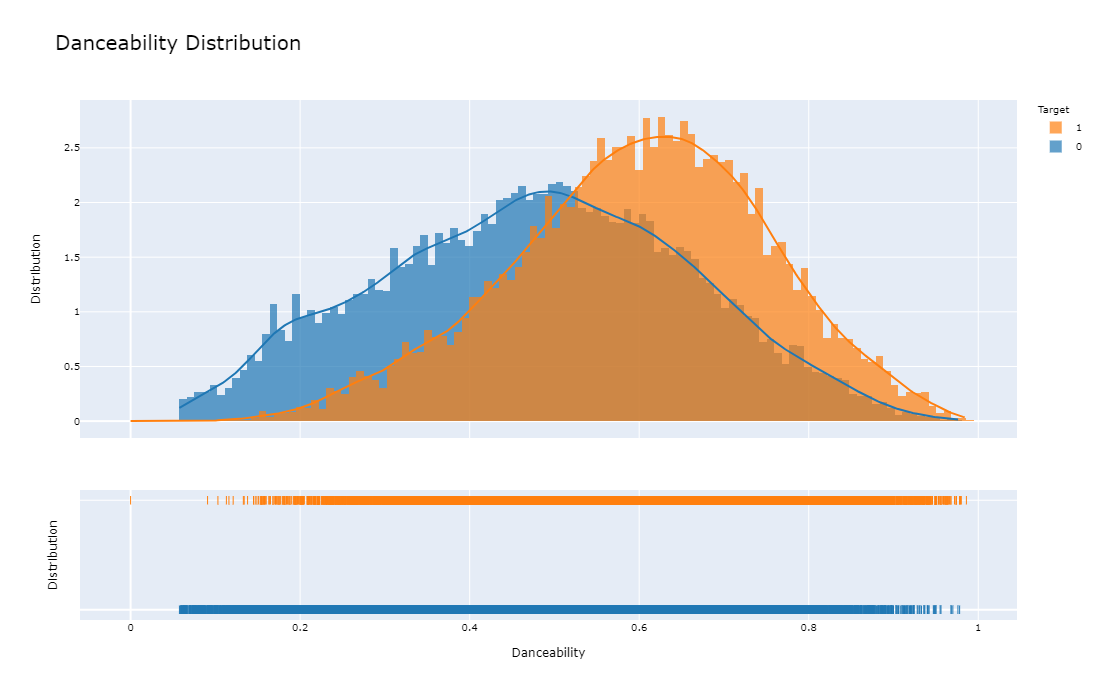

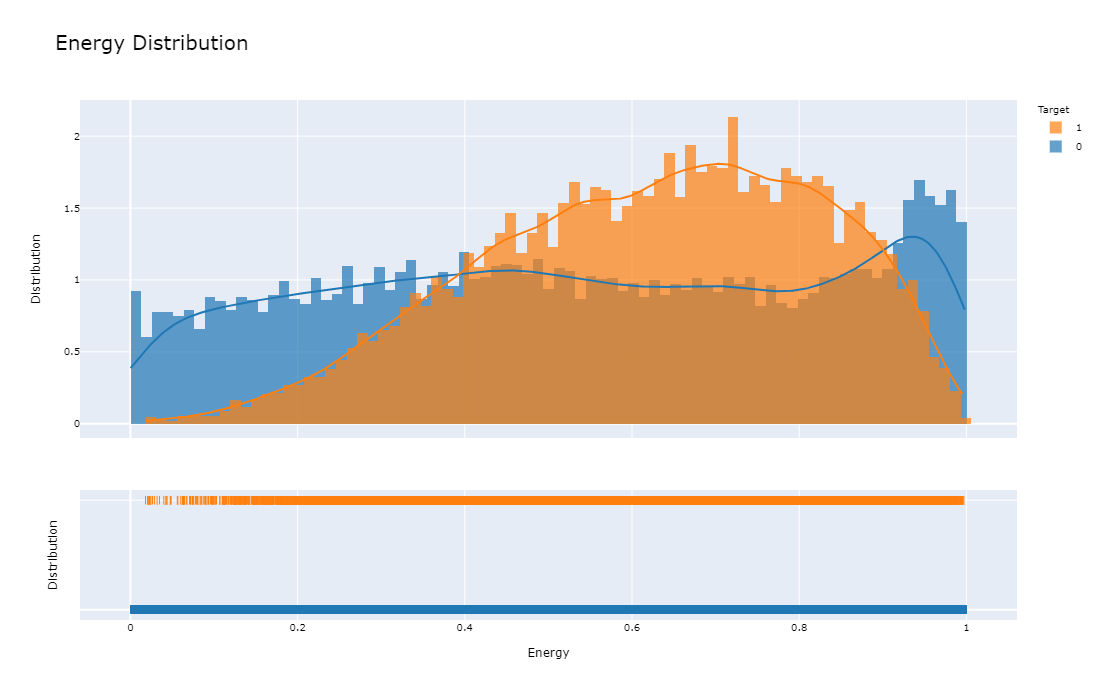

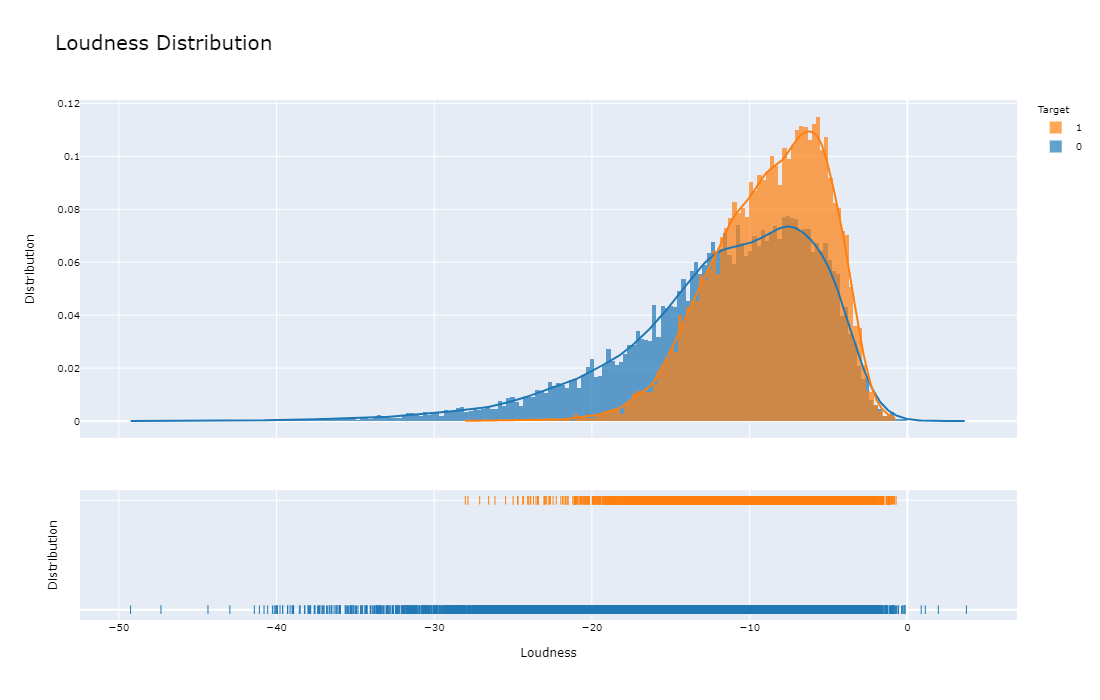

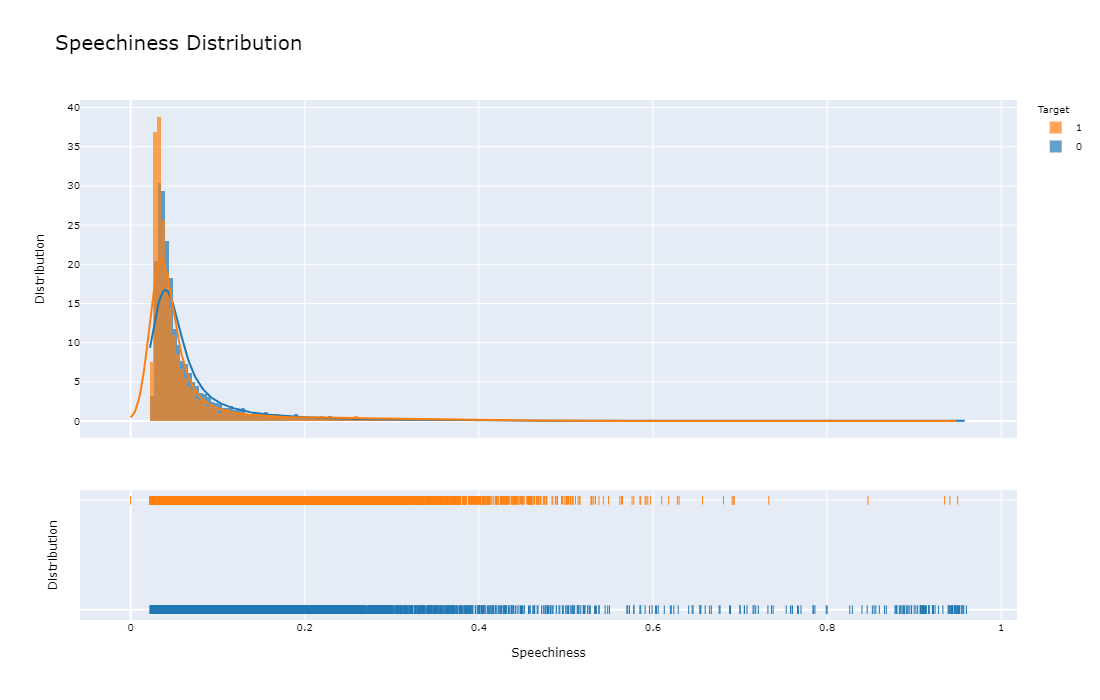

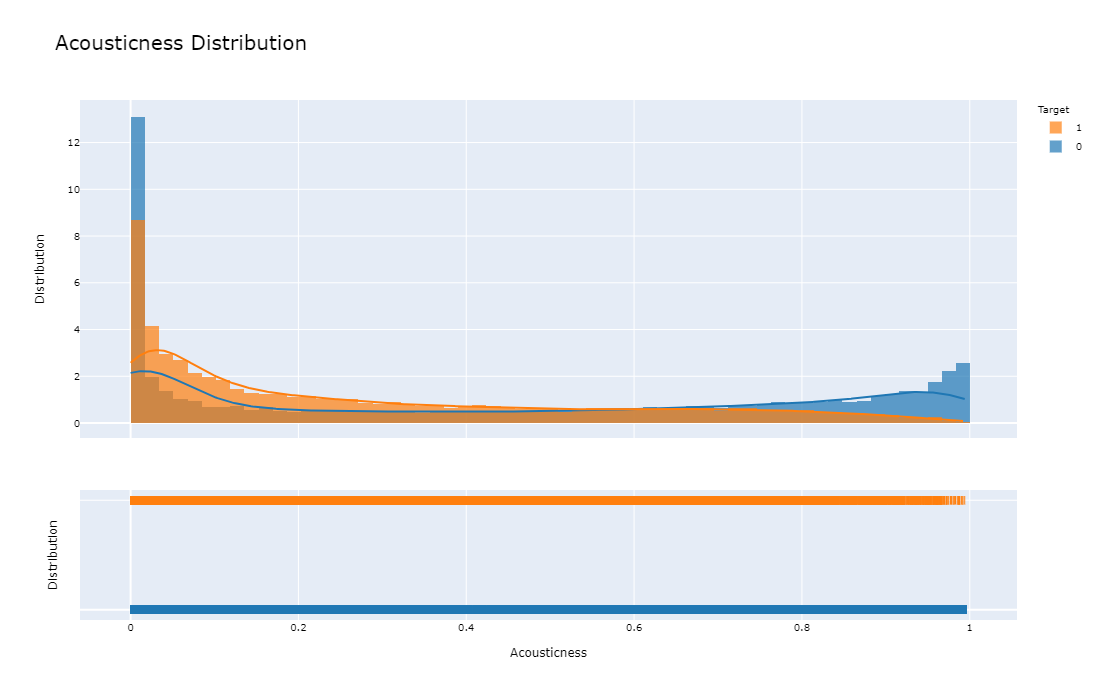

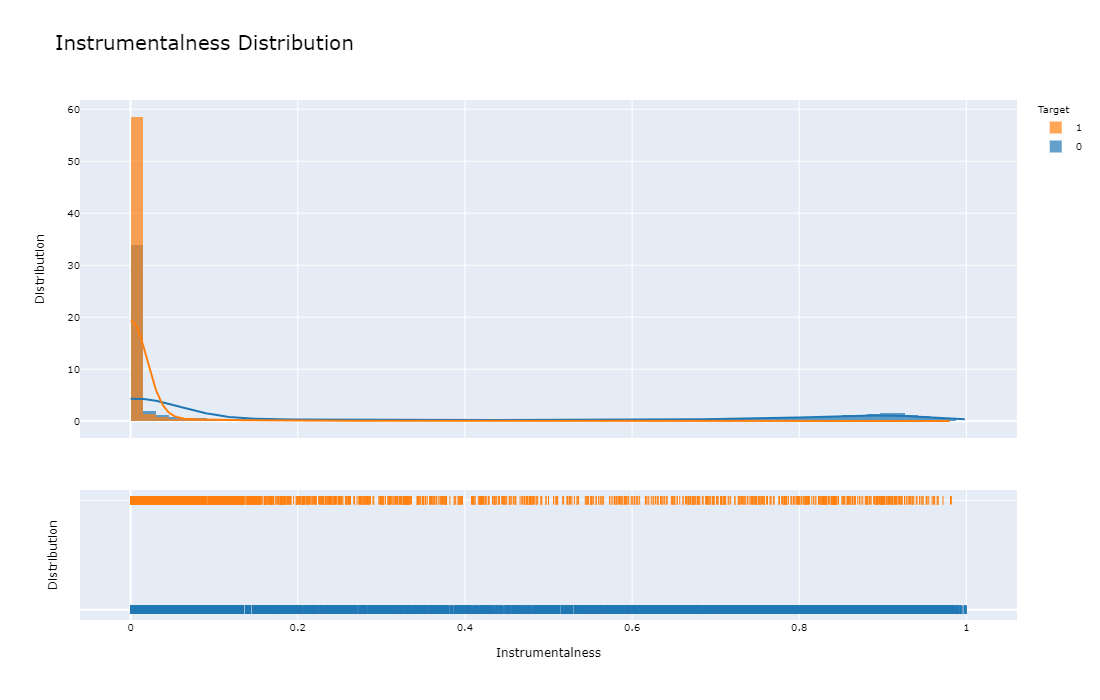

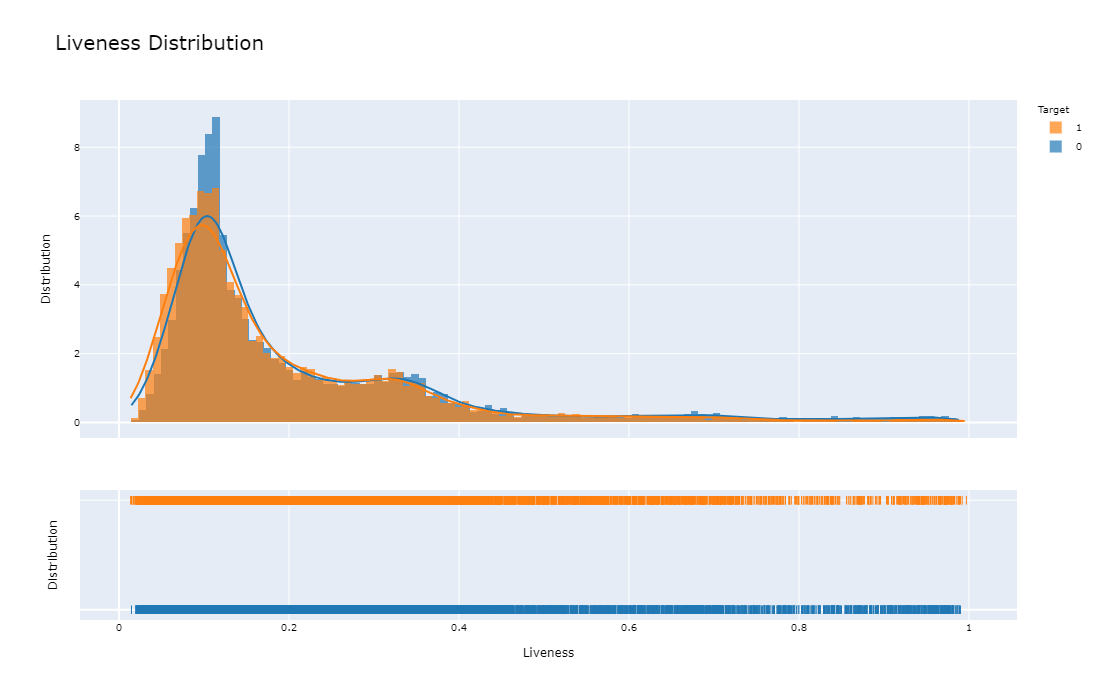

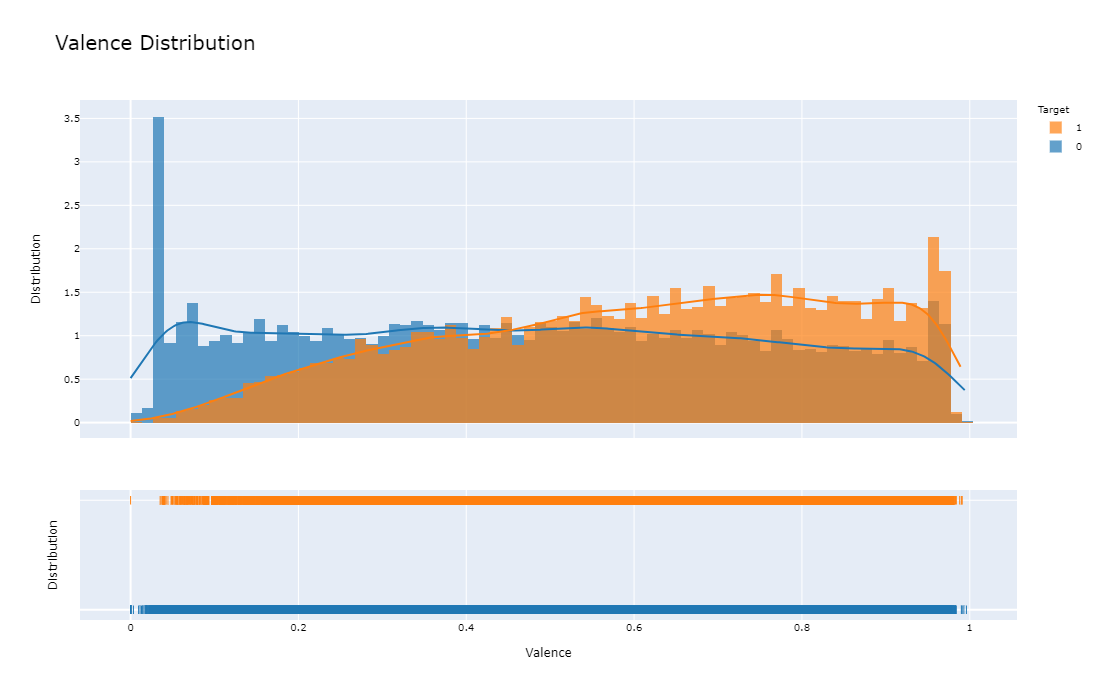

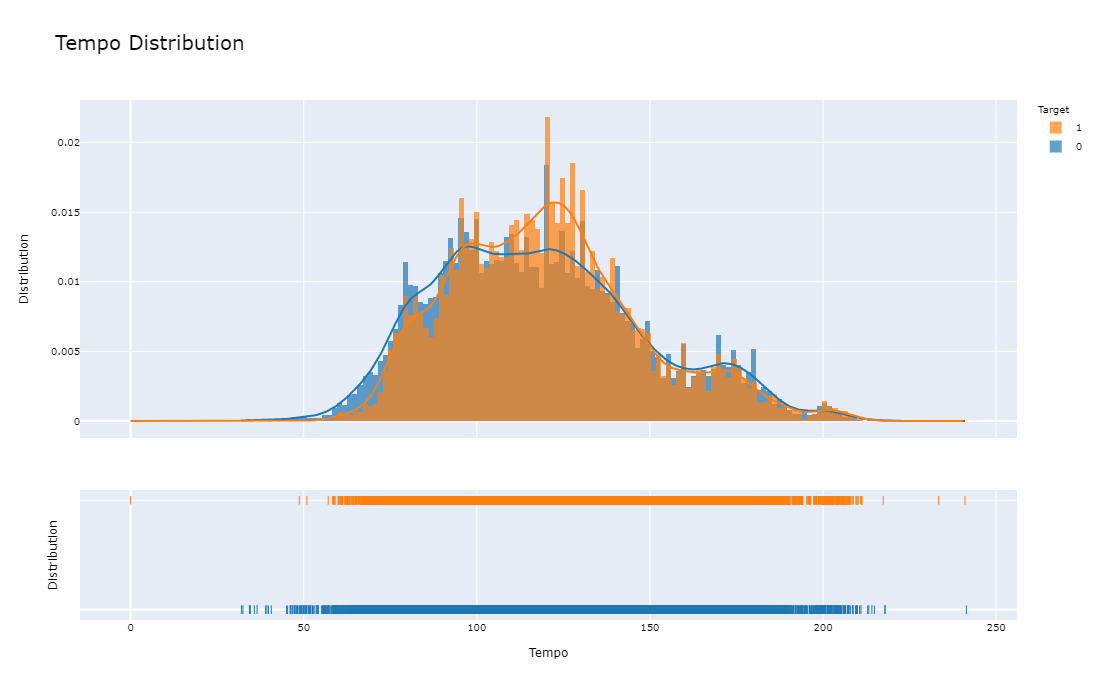

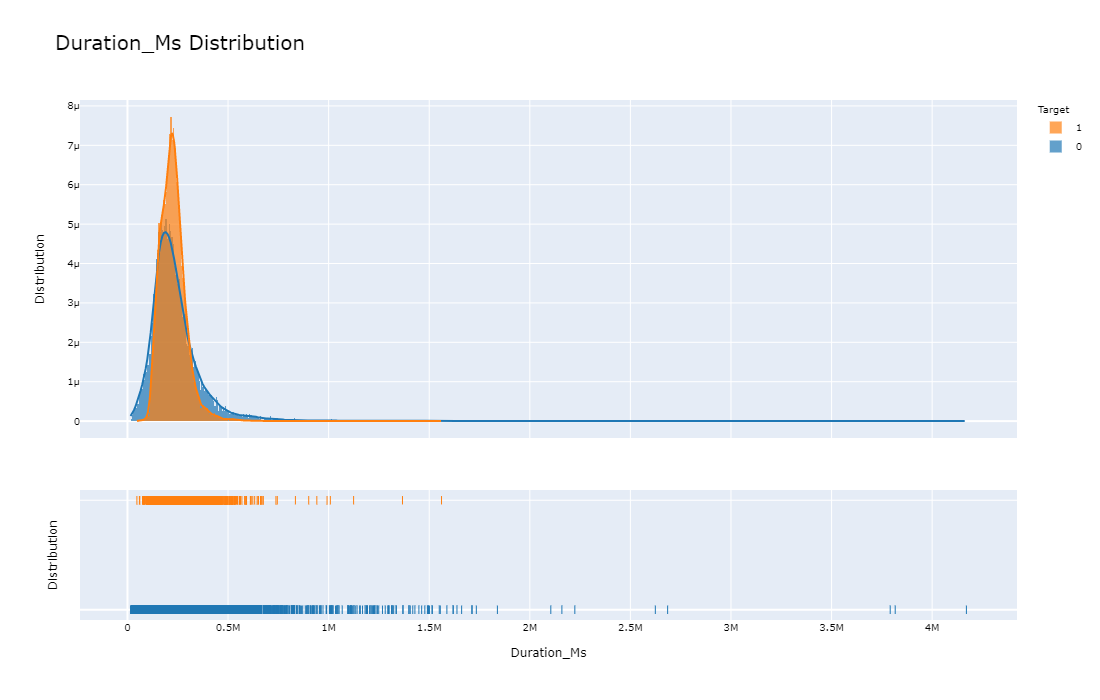

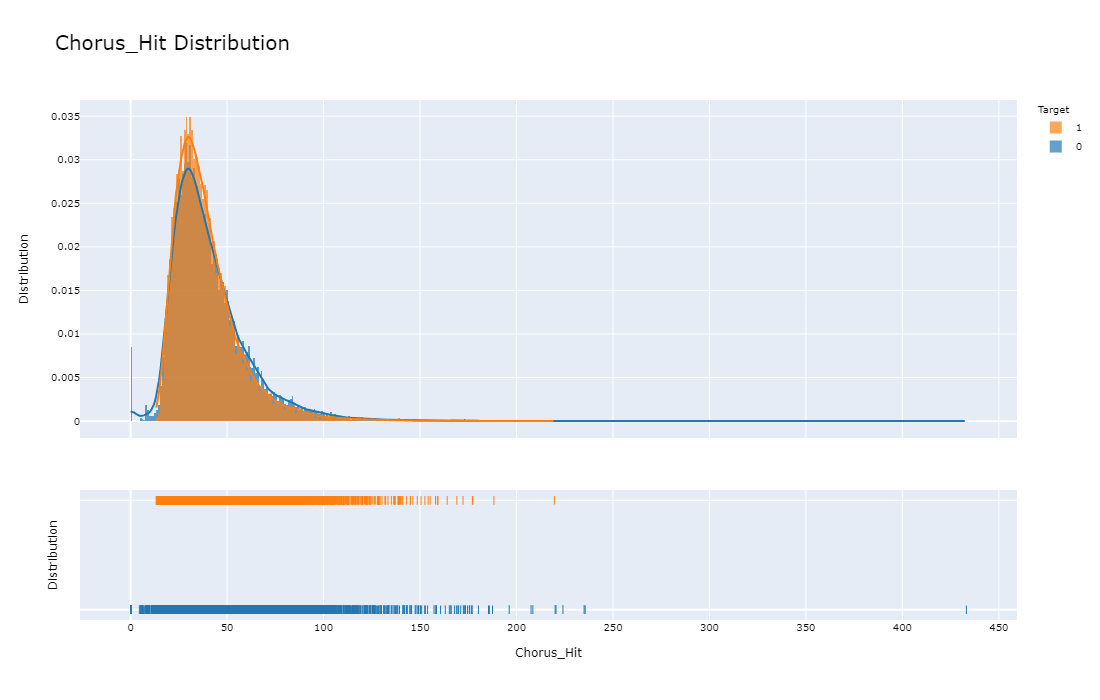

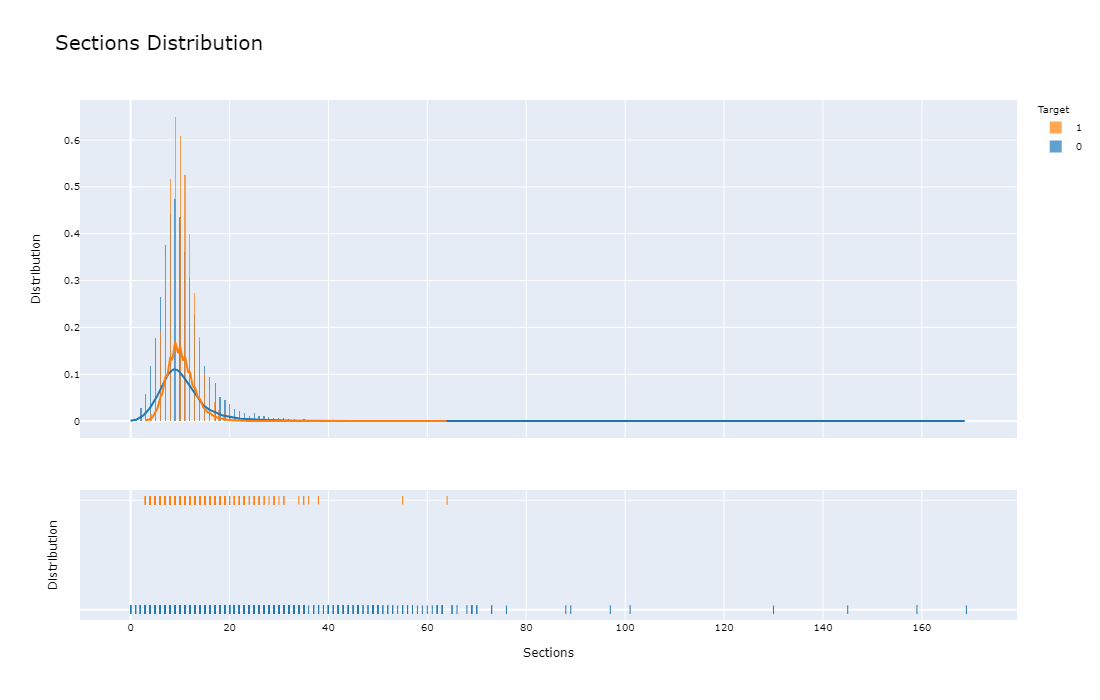

In [6]:
for Var in ContinuousVars:
    DistributionPlot(Train, Var)

## Testing combined variable impact on Target

- Songs that are hits tend to be more danceable and have higher energy together (No-Brainer)
- High Energy but undanceable songs are less likely to be hits, maybe particular Rock/Metal genres?
- Low energy Acoustic Songs tend to be Flops

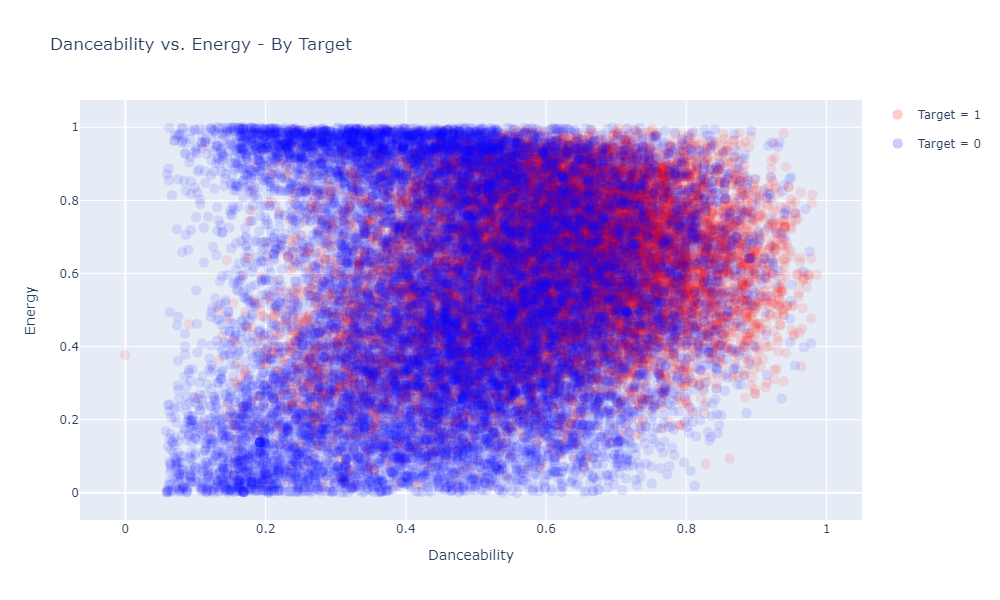

In [7]:
Scatter(Train, "Danceability", "Target", "Energy", "Danceability vs. Energy - By Target")

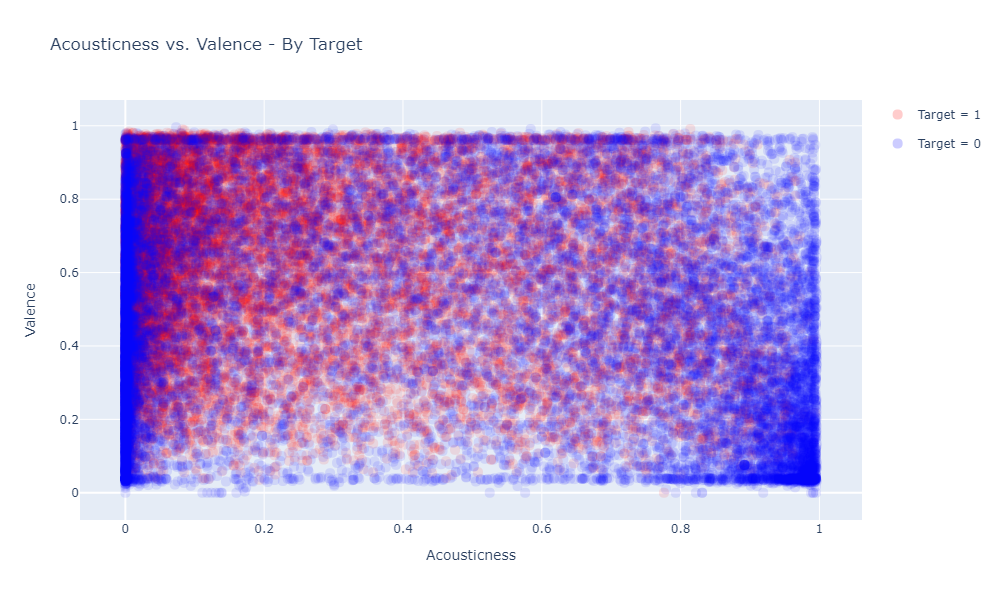

In [8]:
Scatter(Train, "Acousticness", "Target", "Valence", "Acousticness vs. Valence - By Target")

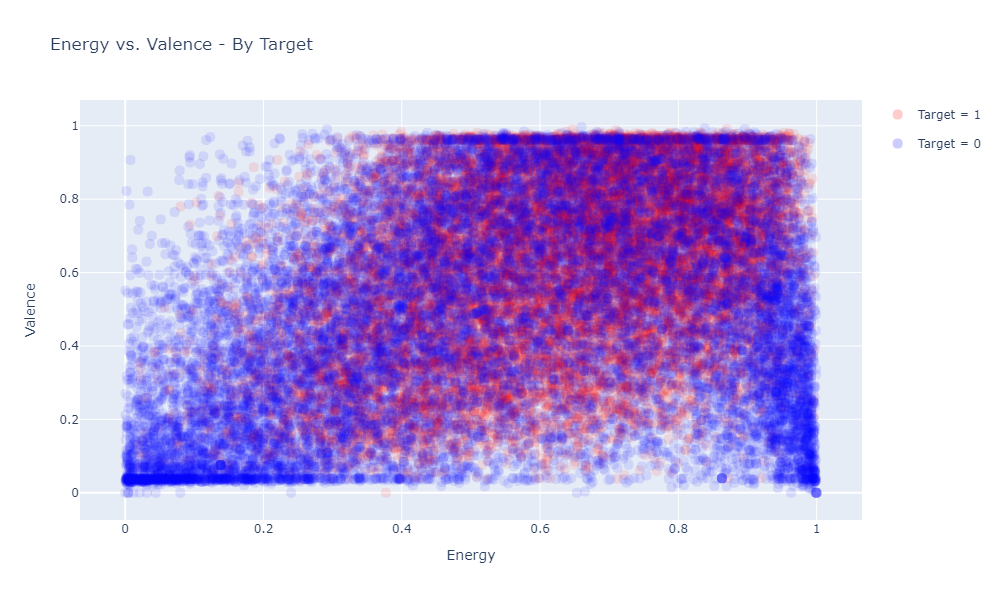

In [9]:
Scatter(Train, "Energy", "Target", "Valence", "Energy vs. Valence - By Target")

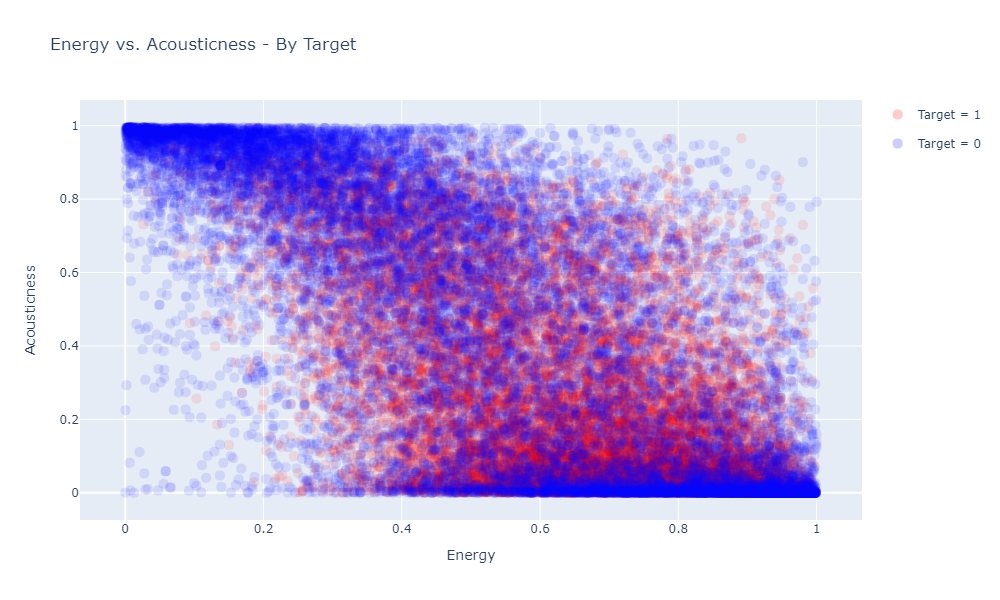

In [10]:
Scatter(Train, "Energy", "Target", "Acousticness", "Energy vs. Acousticness - By Target")

## Bin Variables and Clean
- We can see that, obviously, the most common signature is 4:4.
- We also see the host of non-linear relationships between features and the Target.

We use the optimal binning library in python to find the most optimal ways of binning our variables w.r.t the target. We bin our variables according to these definitions and scale them between 0 and 1, to help with gradient descent and assessing our feature importance.

We also ordinally encode the "Key" variable according to its relationship with the target.

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




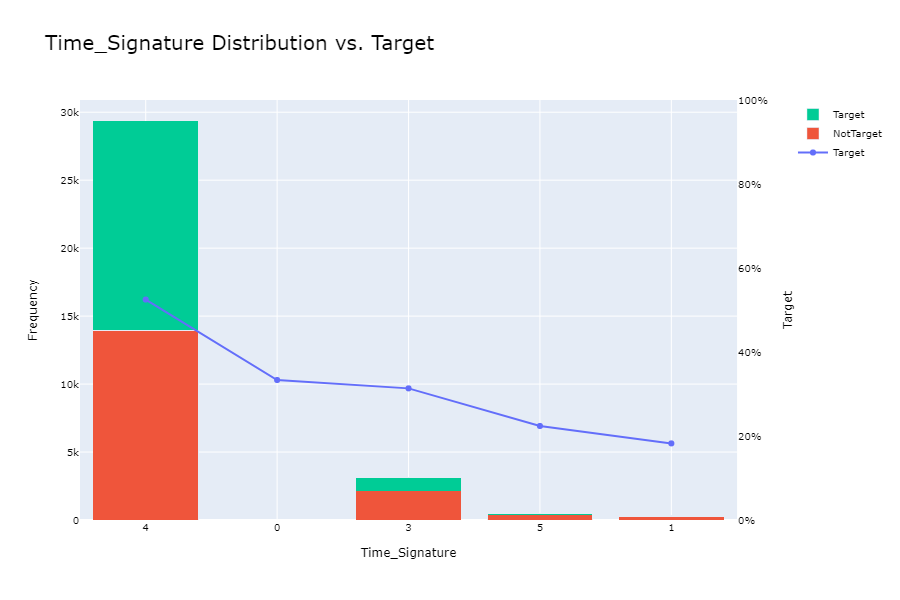

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




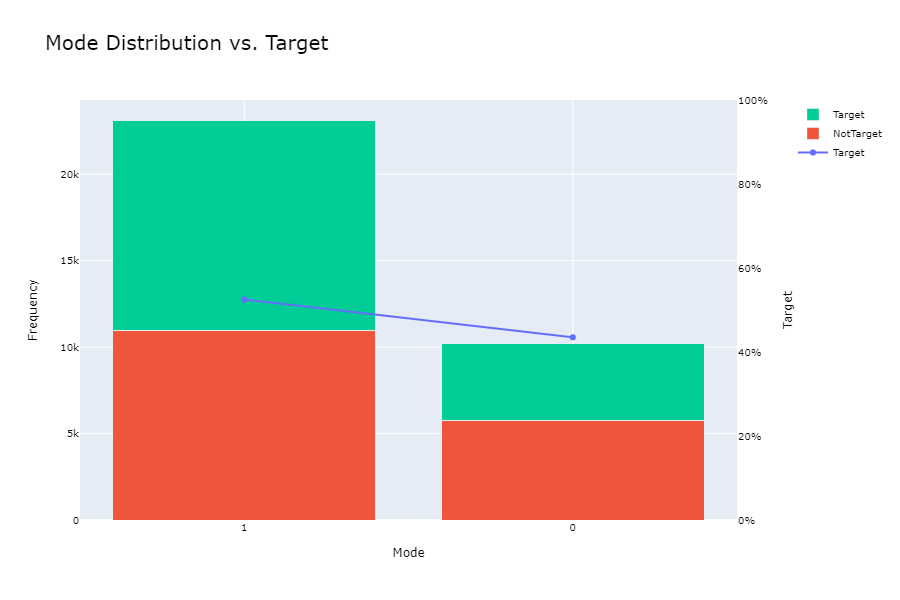

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




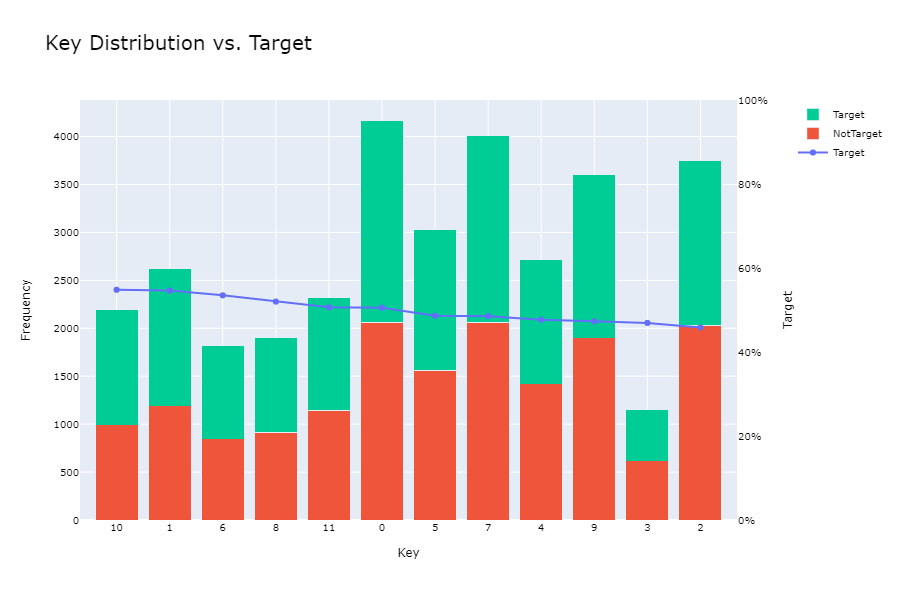

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




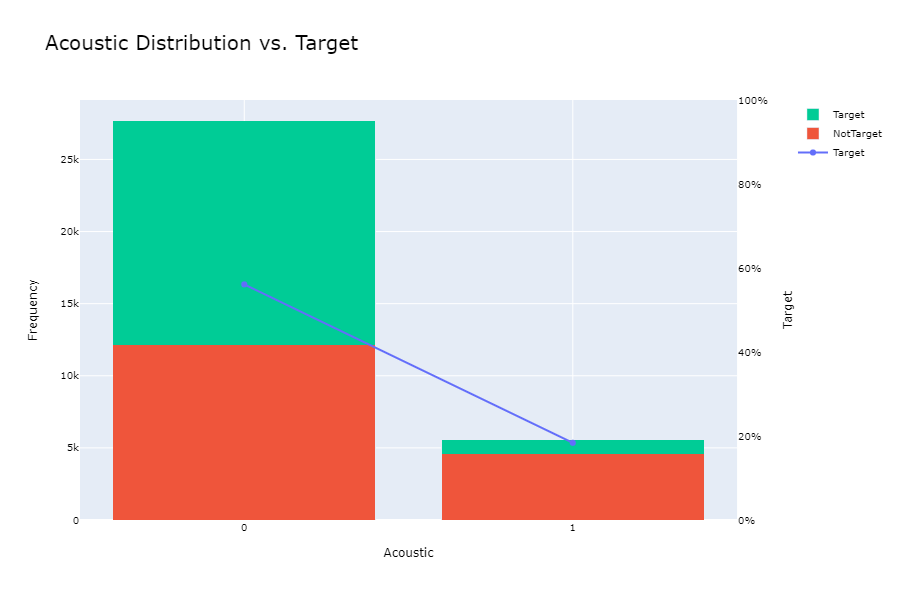

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




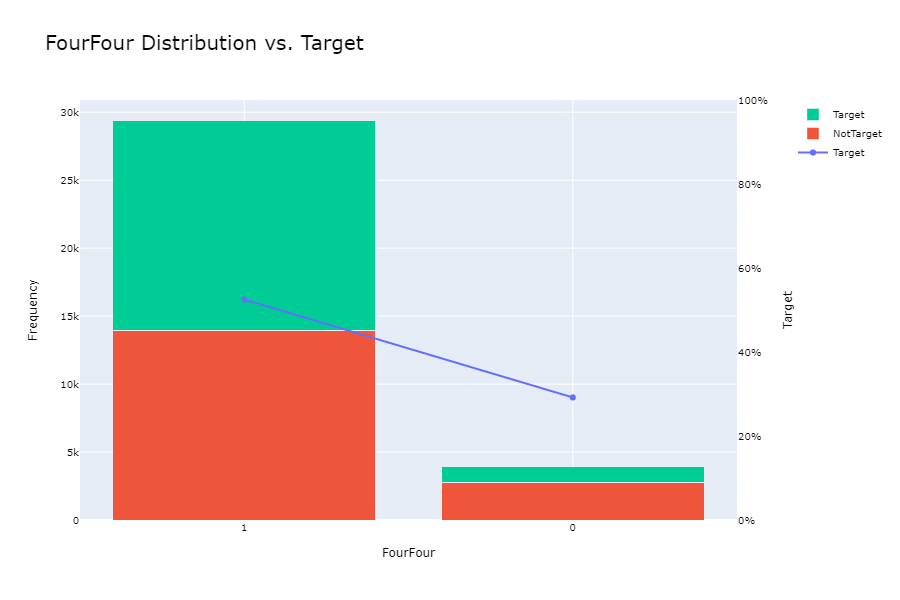

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




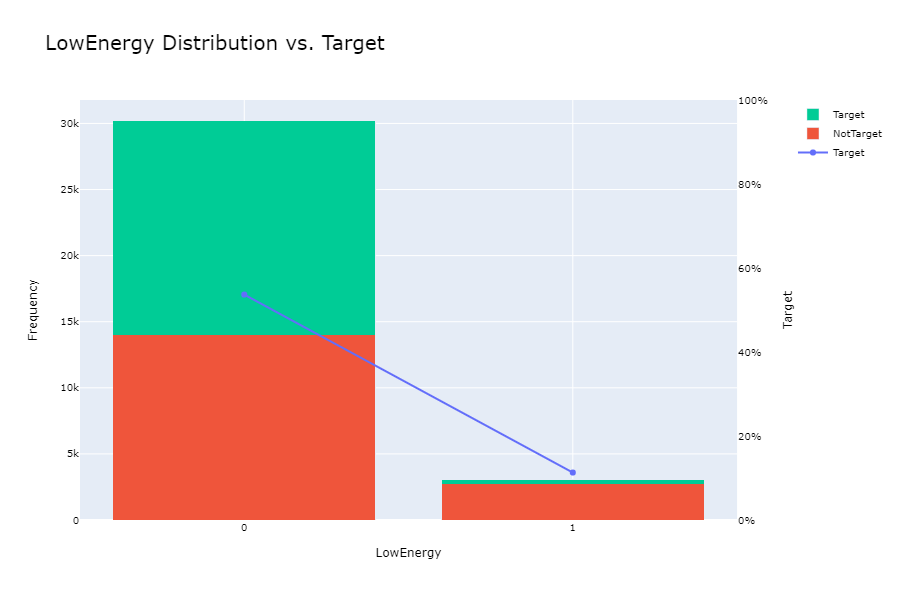

In [11]:
for Variable in DiscreteVars:
    Distribution(Train, "Target", Variable)

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.39254932
    IV (Jeffrey)             0.61993794
    JS (Jensen-Shannon)      0.06788510
    HHI                      0.04333592
    HHI (normalized)         0.01247579
    Cramer's V               0.35342895
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    10.916492  0.000953  0.000354  0.999646
         1      2     0.630709  0.427095  0.206676  0.793324
         2      3     0.890783  0.345265  0.174556  0.825444
         3      4     8.146088  0.004315  0.001770  0.998230
         4      5     0.684593  0.408010  0.201967  0.798033
         5      6     6.366775  0.011628  0.004821  0.995179
         6      7     3.999668  0.045509  0.022761  0.977239
         7      8     1.269607  0.259840  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




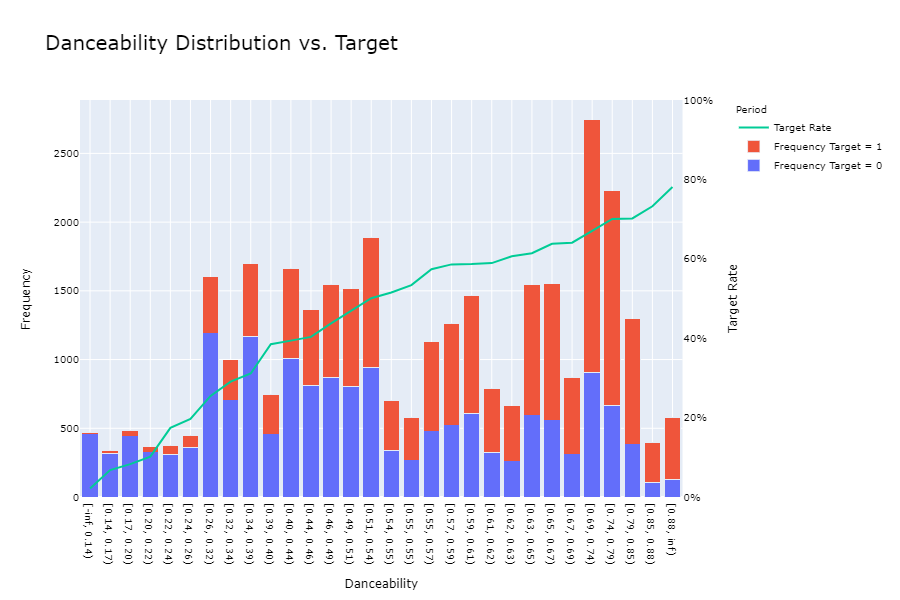

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.37437107
    IV (Jeffrey)             0.68010922
    JS (Jensen-Shannon)      0.07176813
    HHI                      0.04342847
    HHI (normalized)         0.01685704
    Cramer's V               0.35952267
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic       p-value  P[A > B]      P[B > A]
         0      1    17.194652  3.373848e-05  0.000009  9.999910e-01
         1      2     0.297701  5.853270e-01  0.296644  7.033557e-01
         2      3     7.124068  7.605596e-03  0.002709  9.972909e-01
         3      4     5.050855  2.461379e-02  0.012539  9.874608e-01
         4      5     1.679514  1.949890e-01  0.096645  9.033545e-01
         5      6     0.993820  3.188105e-01  0.156829  8.431707e-01
         6      7     5.853951  1.554212e-02  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




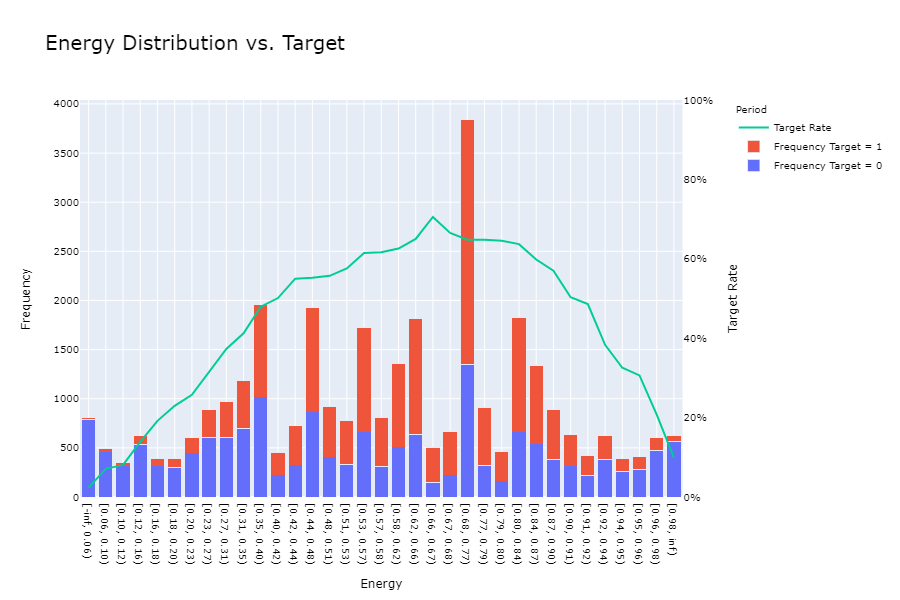

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.29126568
    IV (Jeffrey)             0.57006815
    JS (Jensen-Shannon)      0.05506738
    HHI                      0.06001693
    HHI (normalized)         0.02644611
    Cramer's V               0.30929655
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     9.208452  0.002409  0.001214  0.998786
         1      2     2.785568  0.095117  0.041810  0.958190
         2      3    10.713908  0.001063  0.000437  0.999563
         3      4     3.499030  0.061405  0.030978  0.969022
         4      5     4.489325  0.034107  0.015492  0.984508
         5      6     3.344699  0.067422  0.032217  0.967783
         6      7     2.470513  0.116000  0.058645  0.941355
         7      8     1.119164  0.290098  

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




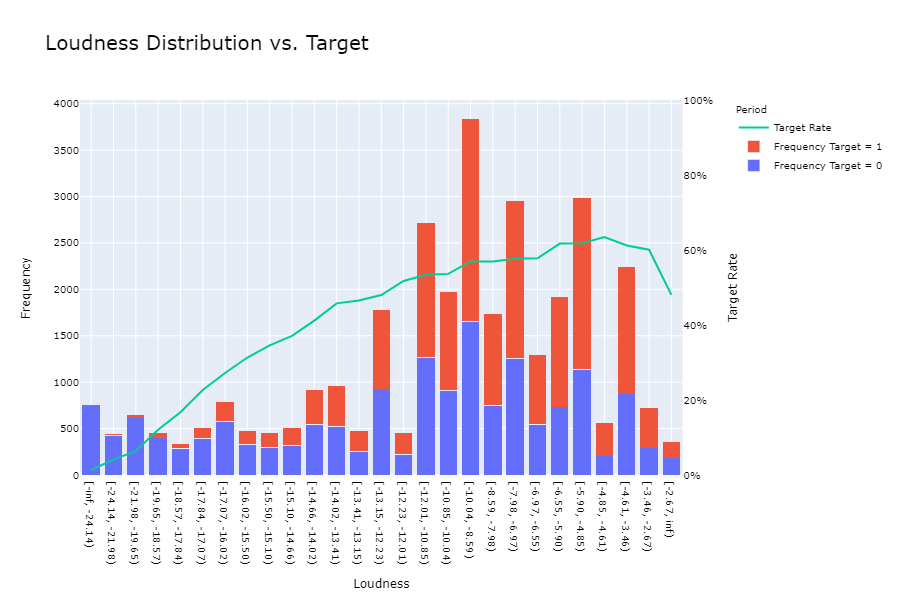

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16526211
    IV (Jeffrey)             0.13916717
    JS (Jensen-Shannon)      0.01685089
    HHI                      0.40566443
    HHI (normalized)         0.36851845
    Cramer's V               0.18093561
    Quality score            0.00002053

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     5.913989  0.015021  0.993743  6.256900e-03
         1      2    11.248048  0.000797  0.999825  1.745742e-04
         2      3     0.007943  0.928984  0.538328  4.616723e-01
         3      4     3.699758  0.054420  0.973047  2.695251e-02
         4      5     0.517152  0.472059  0.764114  2.358856e-01
         5      6     3.264177  0.070809  0.964953  3.504689e-02
         6      7     0.014898  0.902855  0.548272  4.517285e-01
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




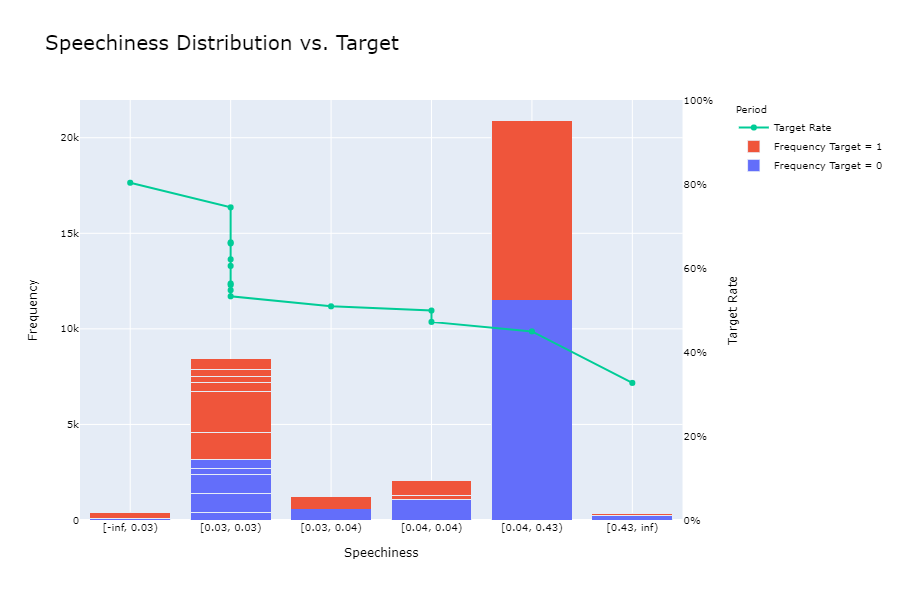

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.44793133
    IV (Jeffrey)             0.97023093
    JS (Jensen-Shannon)      0.09579828
    HHI                      0.03836011
    HHI (normalized)         0.01490548
    Cramer's V               0.41157863
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    11.833044  0.000582  0.000123  0.999877
         1      2    19.206084  0.000012  0.000001  0.999999
         2      3    17.124734  0.000035  0.000007  0.999993
         3      4     2.691545  0.100882  0.049818  0.950182
         4      5     4.275222  0.038672  0.018644  0.981356
         5      6     3.961230  0.046560  0.022802  0.977198
         6      7     0.504920  0.477346  0.238224  0.761776
         7      8     1.018755  0.312814  

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




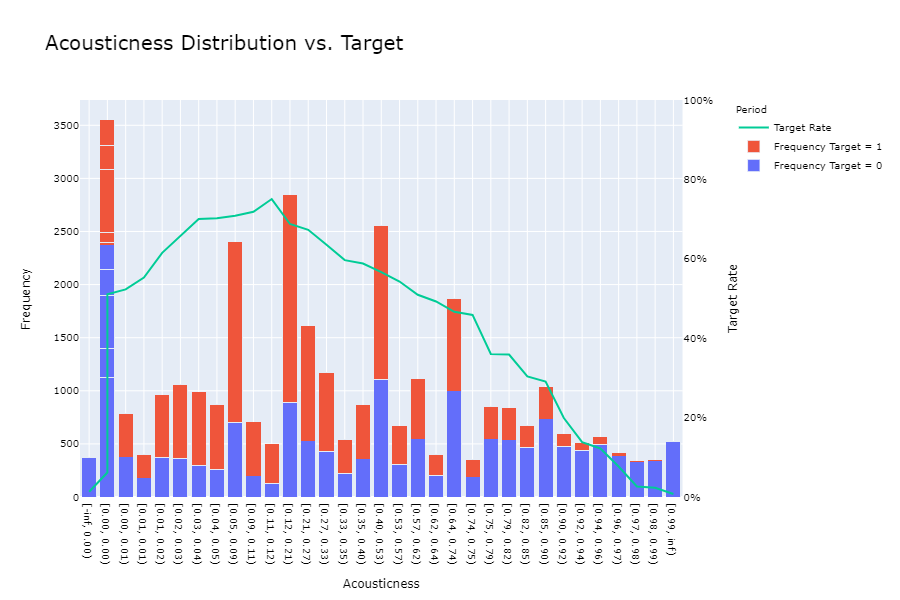

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.47914996
    IV (Jeffrey)             1.08709622
    JS (Jensen-Shannon)      0.11474901
    HHI                      0.11225918
    HHI (normalized)         0.07811531
    Cramer's V               0.45245948
    Quality score            0.00000093

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1    20.321550  0.000007  1.000000  8.779888e-08
         1      2     0.714080  0.398093  0.800233  1.997668e-01
         2      3     0.574464  0.448490  0.774389  2.256110e-01
         3      4     0.316360  0.573803  0.713786  2.862139e-01
         4      5     2.727815  0.098614  0.951093  4.890692e-02
         5      6     0.053770  0.816629  0.591748  4.082519e-01
         6      7     0.470226  0.492883  0.754063  2.459373e-01
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




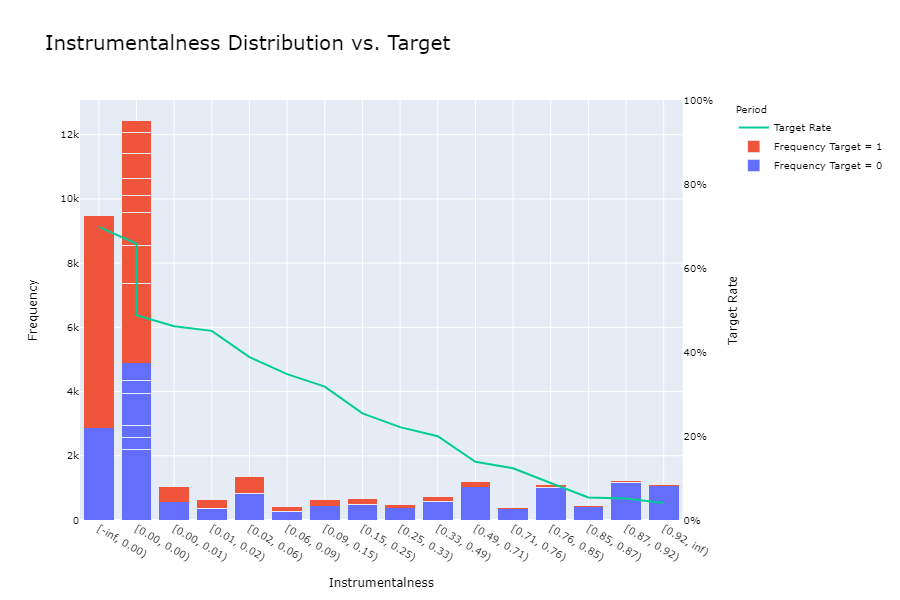

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09029657
    IV (Jeffrey)             0.04996480
    JS (Jensen-Shannon)      0.00614979
    HHI                      0.40421598
    HHI (normalized)         0.36165998
    Cramer's V               0.11007781
    Quality score            0.00058769

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     0.428332  0.512809  0.745547  2.544534e-01
         1      2     2.382074  0.122735  0.940467  5.953330e-02
         2      3     2.288267  0.130355  0.934029  6.597077e-02
         3      4     0.370285  0.542849  0.729173  2.708271e-01
         4      5     2.531504  0.111594  0.944426  5.557385e-02
         5      6     0.180316  0.671102  0.664877  3.351233e-01
         6      7     0.106535  0.744124  0.628178  3.718218e-01
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




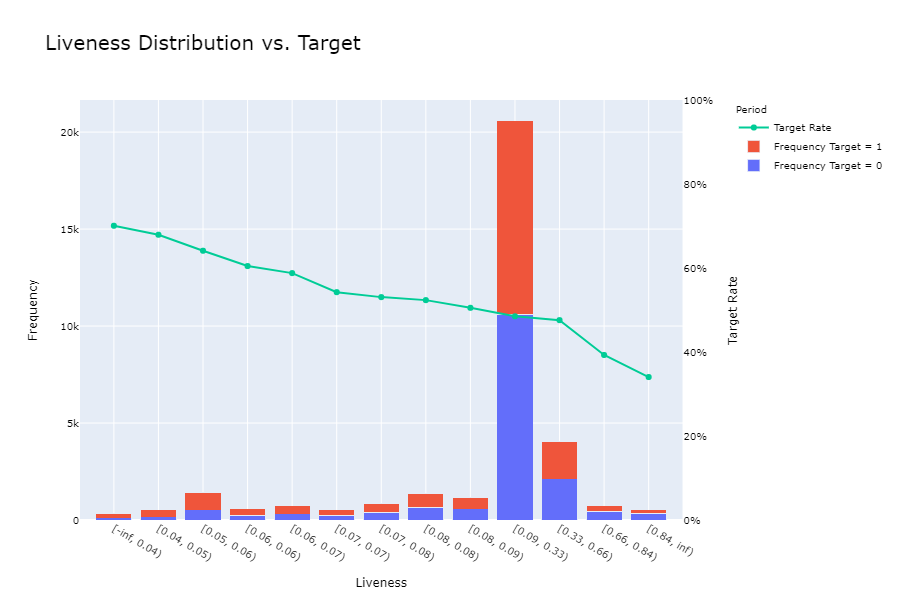

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28095696
    IV (Jeffrey)             0.48768199
    JS (Jensen-Shannon)      0.04645877
    HHI                      0.07305342
    HHI (normalized)         0.03275140
    Cramer's V               0.28537975
    Quality score            0.00001373

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     9.617688  0.001927  0.000384  0.999616
         1      2     9.653344  0.001890  0.000631  0.999369
         2      3     1.483593  0.223213  0.113420  0.886580
         3      4    17.949169  0.000023  0.000004  0.999996
         4      5     1.526723  0.216605  0.109812  0.890188
         5      6     0.601869  0.437866  0.216584  0.783416
         6      7     8.002174  0.004672  0.002029  0.997971
         7      8     6.602784  0.010182  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




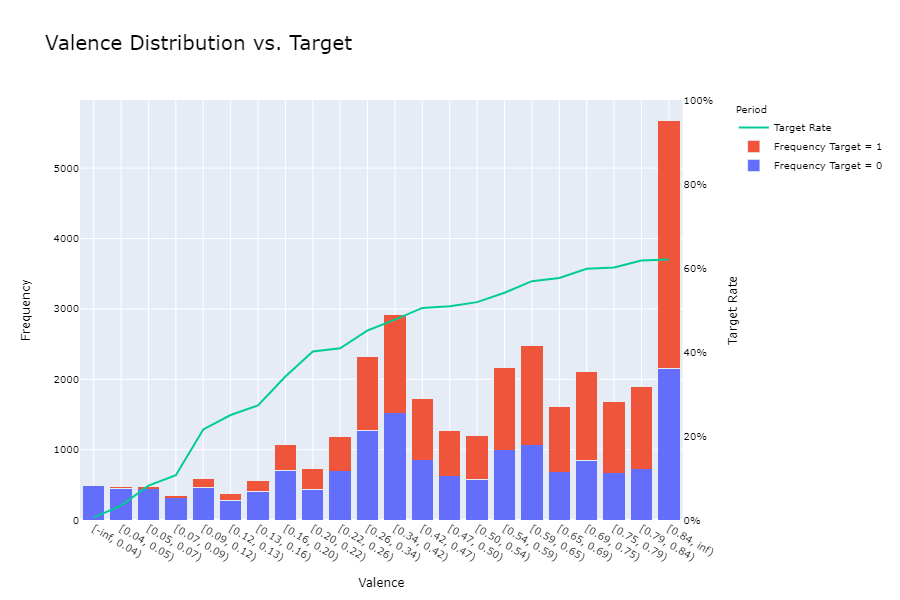

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07147002
    IV (Jeffrey)             0.04205883
    JS (Jensen-Shannon)      0.00500439
    HHI                      0.30540313
    HHI (normalized)         0.24225796
    Cramer's V               0.09789464
    Quality score            0.00042801

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1    12.294590  4.542731e-04  1.515639e-04  0.999848
         1      2    17.410284  3.011920e-05  5.814292e-06  0.999994
         2      3     0.699323  4.030113e-01  2.002436e-01  0.799756
         3      4     0.053356  8.173236e-01  4.085278e-01  0.591472
         4      5    29.896314  4.557785e-08  2.118399e-08  1.000000
         5      6     0.013595  9.071773e-01  4.534607e-01  0.546539
         6      7     2.812610  9.352608e-02  9

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




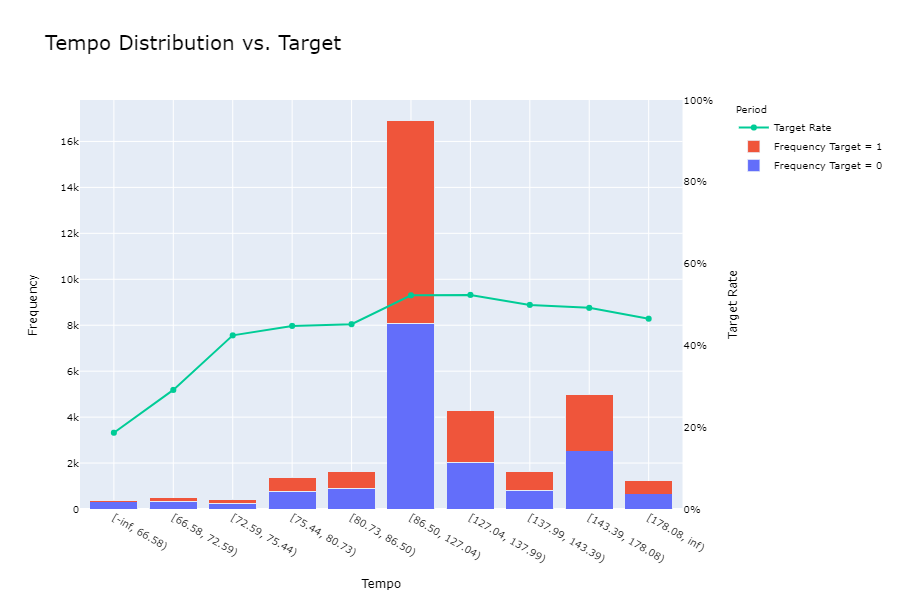

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.29198685
    IV (Jeffrey)             0.51312832
    JS (Jensen-Shannon)      0.05000320
    HHI                      0.05674648
    HHI (normalized)         0.02726981
    Cramer's V               0.29641349
    Quality score            0.00000001

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]      P[B > A]
         0      1     5.005914  2.526087e-02  8.467233e-03  9.915328e-01
         1      2    13.702554  2.141630e-04  4.633548e-05  9.999537e-01
         2      3    25.122012  5.381506e-07  3.801672e-08  1.000000e+00
         3      4    17.923104  2.300119e-05  5.306446e-06  9.999947e-01
         4      5     3.466843  6.261070e-02  3.037443e-02  9.696256e-01
         5      6     7.106770  7.679336e-03  3.560446e-03  9.964396e-01
         6      7  

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




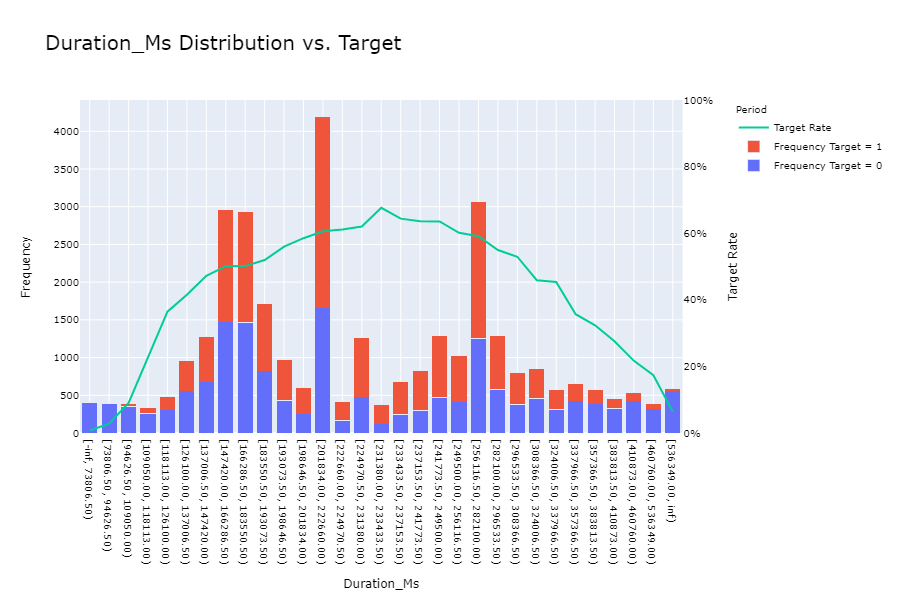

UNKNOWN
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Significance tests

    None

None


C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




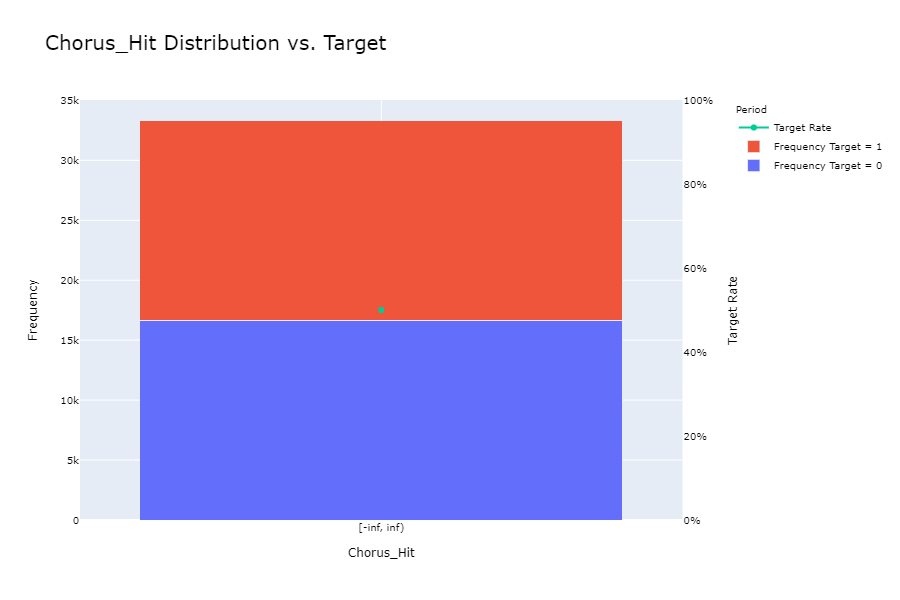

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23522973
    IV (Jeffrey)             0.34448382
    JS (Jensen-Shannon)      0.03658510
    HHI                      0.08935801
    HHI (normalized)         0.04142948
    Cramer's V               0.25640348
    Quality score            0.01116795

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]      P[B > A]
         0      1    17.996003  2.213693e-05  2.647367e-06  9.999974e-01
         1      2    42.355270  7.611099e-11  1.035119e-12  1.000000e+00
         2      3    64.243737  1.099409e-15  1.809854e-18  1.000000e+00
         3      4    24.250580  8.458159e-07  1.643622e-07  9.999998e-01
         4      5    15.026322  1.060221e-04  3.504308e-05  9.999650e-01
         5      6    19.123305  1.225394e-05  2.507900e-06  9.999975e-01
         6      7   

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




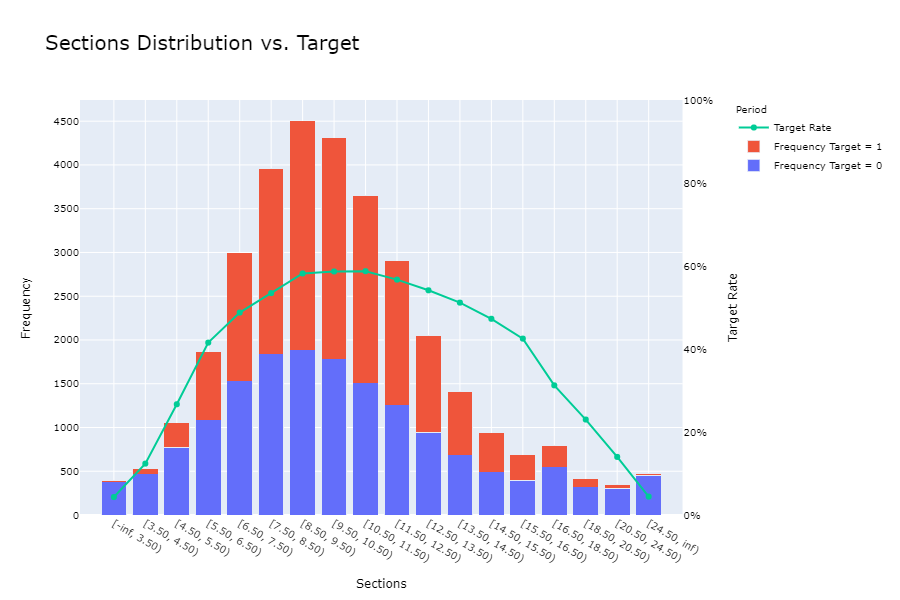

In [100]:
BinOut = {}

for Variable in ContinuousVars:
    BinOut = BinVariable(Train, "Target", Variable, BinOut, Trend="auto")

In [101]:
Variables = ["Mode", "Acoustic", "FourFour", "LowEnergy", "Liveness", "Instrumentalness", "Danceability"]

SquareVariables = ["Loudness", "Duration_Ms", "Energy", "Acousticness", "Tempo", "Sections"]

SqrtVariables = ["Valence"]

OrdinalVariables = ["Key"]

ModVars = Variables+SquareVariables+SqrtVariables+OrdinalVariables
ModVarsClean = [str(Variable)+"Clean" for Variable in ModVars]

In [102]:
for Variable in ModVars:
    Train[Variable+"Clean"] = Train[Variable]
    Test[Variable+"Clean"] = Test[Variable]

In [103]:
for Variable in ContinuousVars:
    
    Bins = BinOut[Variable].tolist()
    Bins.insert(0, -np.inf)
    Bins.insert(len(Bins), np.inf)
    
    Train[Variable + "Clean"] = pd.cut(Train[Variable], bins=Bins, labels = range(0, len(Bins)-1)).values
    Test[Variable + "Clean"] = pd.cut(Test[Variable], bins=Bins, labels = range(0, len(Bins)-1)).values

In [104]:
for Variable in ModVarsClean:
    Train[Variable]  = pd.to_numeric(Train[Variable])
    Test[Variable]  = pd.to_numeric(Test[Variable])

for Variable in SquareVariables:
    Train[str(Variable)+"SquaredClean"] = Train[Variable+"Clean"]**2
    Test[str(Variable)+"SquaredClean"] = Test[Variable+"Clean"]**2
    ModVarsClean.append(str(Variable)+"SquaredClean")
    
for Variable in SqrtVariables:
    Train[str(Variable)+"SqrtClean"] = Train[Variable+"Clean"]**0.5
    Test[str(Variable)+"SqrtClean"] = Test[Variable+"Clean"]**0.5
    ModVarsClean.append(str(Variable)+"SqrtClean")
    
for Variable in OrdinalVariables:
    Index = pd.pivot_table(Train, index=Variable, values="Target", aggfunc="mean").sort_values(by="Target", ascending=False).index.values
    Labels = {}
    for i in range(len(Index)):
        Labels[Index[i]] = i

    Train[str(Variable)+"Clean"] = Train.Key.map(Labels)
    Test[str(Variable)+"Clean"] = Test.Key.map(Labels)

In [105]:
for Variable in ModVarsClean:
    Scaler = MinMaxScaler(feature_range=(-1, 1))
    Scaler = Scaler.fit(Train[Variable].values.reshape(-1, 1))
    Train[Variable] = Scaler.transform(Train[Variable].values.reshape(-1, 1))
    Test[Variable] = Scaler.transform(Test[Variable].values.reshape(-1, 1))

## Variable Correlations

In [106]:
Correlation(Train, sorted(ModVarsClean)+["Target"], "CorrelationPlot")

In [107]:
OverFit = []
for i in Train.columns:
    Counts = Train[i].value_counts()
    Zeros = Counts.iloc[0]
    if Zeros / len(Train) * 100 > 99.94:
        OverFit.append(i)
        print(Counts)

OverFit = list(OverFit)
print(OverFit)
#Train = Train.drop(OverFit, axis=1)
#print(Train.shape)

Train    33280
Name: Population, dtype: int64
0    33280
Name: Chorus_HitClean, dtype: int64
['Population', 'Chorus_HitClean']


## Modelling

We choose our selection of classifiers:

- Logistic Regression
- Decision Tree
- Random Forest

We then perform a grid search on each (not including logistic regression) to find the optimal parameters and plot feature importances. Finally, we compare our models using a series of metrics.

As the variables have been scaled between -1 and 1, the coefficients in the logistic regression model allow us to see feature importances. We can see that the two most important variables in determining the target are Duration and Energy. When fitting this model, l1 (Lasso) regularisation was used, meaning the fitting process would shrink any irrelevant coefficients to 0 and therefore performing feature selection, however, all features were significant.

In both the Decision Tree and the Random Forest classifiers, a grid search was used to determine the optimal parameters. This increased training time down to the fact that grid search is exhaustive, testing all possible combinations of the parameter grid. The parameter grid included max_depth and n_samples_split. n_estimators was used for the Random Forest Classifier.

- max_depth: Maximum depth of the tree, or number of layers of splits/nodes.
- min_samples_split: Minimum number of samples required to split a node further.
- n_estimators: Number of weak learners in the Random Forest Classifier.

All three parameters help to reduce overfitting, by managing how complex the model is.

For both the Decision Tree and Random Forest classifiers, instrumentalness is the most important feature. This is measured by combining information about the number of samples that reached this node during training and the decrease in gini impurity provides.

In [108]:
X = ['AcousticClean', 'DanceabilityClean', 'Duration_MsClean', 'Duration_MsSquaredClean'
                , 'EnergyClean', 'EnergySquaredClean', 'FourFourClean', 'InstrumentalnessClean', 'KeyClean'
                , 'LivenessClean', 'LoudnessClean', 'LoudnessSquaredClean', 'LowEnergyClean', 'ModeClean'
                , 'SectionsClean', 'SectionsSquaredClean', 'ValenceClean', 'ValenceSqrtClean']

Y = "Target"

In [109]:
Scores = {}
Precisions = {}
Recalls = {}
Aucs = {}

### Logistic Regression

In [110]:
Mod = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

In [111]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.coef_[0][i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

In [112]:
Aucs["LogisticRegressionTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["LogisticRegressionTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["LogisticRegressionTrain"] = precision_score(TrainPreds, Train[Y])
Scores["LogisticRegressionTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["LogisticRegressionTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["LogisticRegressionTest"] = recall_score(TestPreds, Test[Y])
Precisions["LogisticRegressionTest"] = precision_score(TestPreds, Test[Y])
Scores["LogisticRegressionTest"] = accuracy_score(TestPreds, Test[Y])

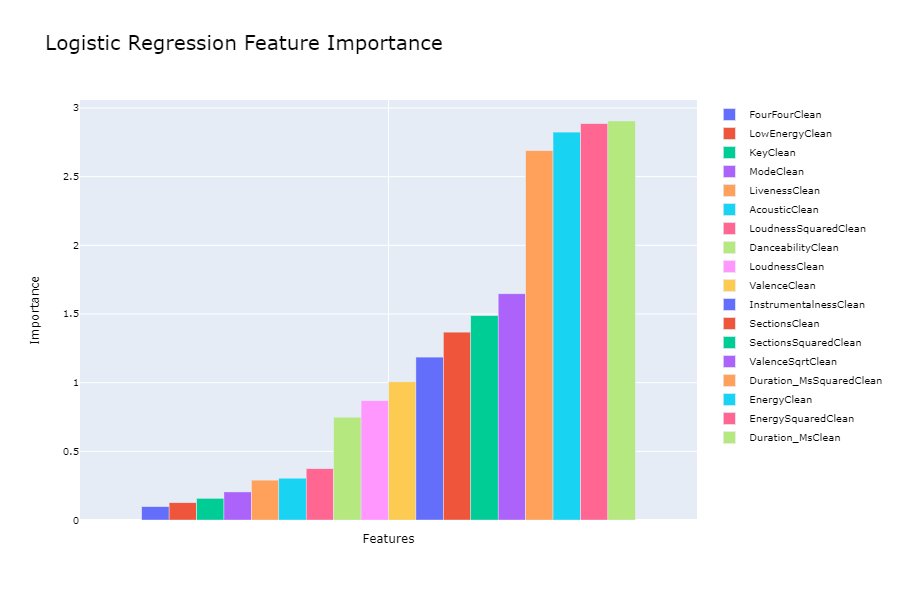

In [113]:
BarPlot(FeatureImportance, "Logistic Regression Feature Importance")

### Decision Tree

In [114]:
ParamGrid = {'max_depth': np.arange(3, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 10)]
            }

Mod = GridSearchCV(tree.DecisionTreeClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Decision Tree Best Params: {}'.format(Mod.best_params_))

Mod = tree.DecisionTreeClassifier(max_depth = Mod.best_params_["max_depth"]
                                  , min_samples_split = Mod.best_params_["min_samples_split"])
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Decision Tree Best Params: {'max_depth': 7, 'min_samples_split': 665}


In [115]:
Aucs["DecisionTreeTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["DecisionTreeTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["DecisionTreeTrain"] = precision_score(TrainPreds, Train[Y])
Scores["DecisionTreeTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["DecisionTreeTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["DecisionTreeTest"] = recall_score(TestPreds, Test[Y])
Precisions["DecisionTreeTest"] = precision_score(TestPreds, Test[Y])
Scores["DecisionTreeTest"] = accuracy_score(TestPreds, Test[Y])

In [116]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

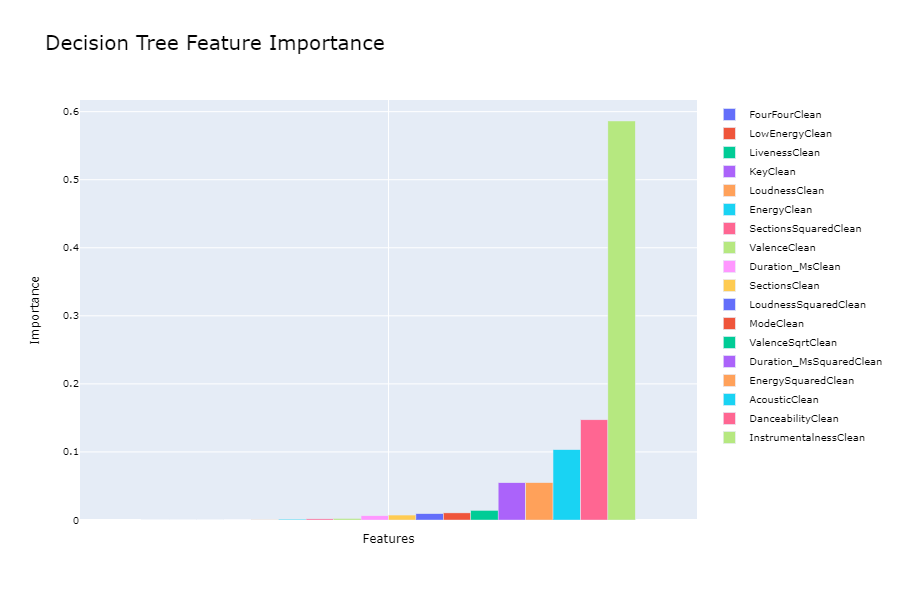

In [117]:
BarPlot(FeatureImportance, "Decision Tree Feature Importance")

### Random Forest

In [118]:
ParamGrid = {'n_estimators': np.arange(100, 200, 50)
             , 'max_depth': np.arange(5, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 5)]
            }

Mod = GridSearchCV(RandomForestClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Random Forest Best Params: {}'.format(Mod.best_params_))

Mod = RandomForestClassifier(max_depth = Mod.best_params_["max_depth"]
                             , n_estimators = Mod.best_params_["n_estimators"]
                             , min_samples_split = Mod.best_params_["min_samples_split"])

Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Random Forest Best Params: {'max_depth': 9, 'min_samples_split': 332, 'n_estimators': 150}


In [119]:
Aucs["RandomForestTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["RandomForestTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["RandomForestTrain"] = precision_score(TrainPreds, Train[Y])
Scores["RandomForestTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["RandomForestTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["RandomForestTest"] = recall_score(TestPreds, Test[Y])
Precisions["RandomForestTest"] = precision_score(TestPreds, Test[Y])
Scores["RandomForestTest"] = accuracy_score(TestPreds, Test[Y])

In [120]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

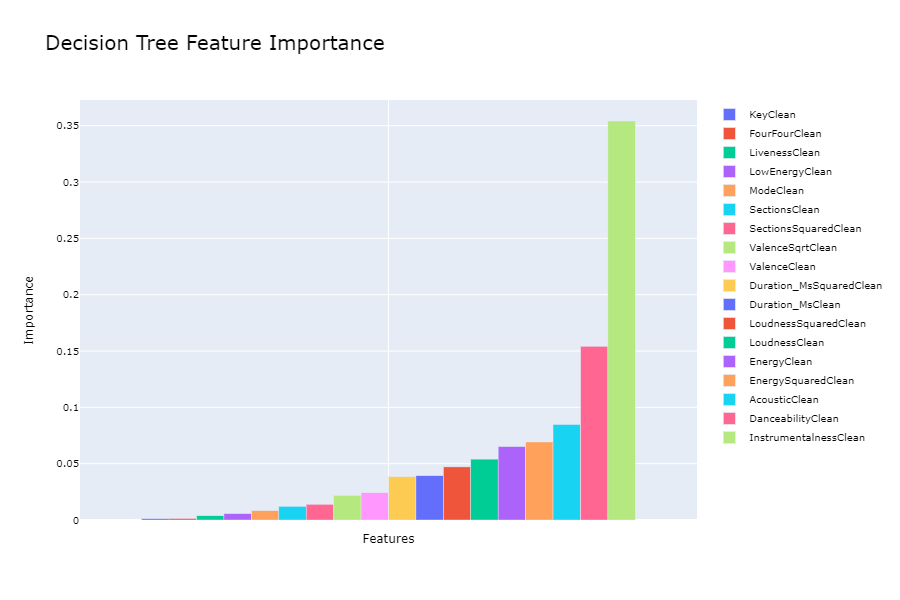

In [121]:
BarPlot(FeatureImportance, "Decision Tree Feature Importance")

## Model Comparison

In most cases, it is useful to decide on a single metric for which to compare models. The choice of metric will often depend on your specific use case. If you were mainly concerned about minimising false negatives, you might choose Recall. Otherwise, you might use Precision. F1 score takes into account both Precision and Recall, giving a more balanced view. For simplicity, I will use the F1 score to compare models, making our model of choice the Random Forest Classifier.

A practical application of this project would be for a Record Company to use these techniques to determine which artists they would like to sign, judging by the features of their top songs. In this case, you could argue that the user would be mainly concerned with false negatives, as they'd be trying to minimise the event of signing an artist that Flops. Which would make Recall the metric of choice.

In [122]:
Comparison = pd.DataFrame()
Models = ["LogisticRegression", "DecisionTree", "RandomForest"]

Comparison["ScoreTrain"] = [Scores[str(Model)+"Train"] for Model in Models]
Comparison["ScoreTest"] = [Scores[str(Model)+"Test"] for Model in Models]

Comparison["PrecisionsTrain"] = [Precisions[str(Model)+"Train"] for Model in Models]
Comparison["PrecisionsTest"] = [Precisions[str(Model)+"Test"] for Model in Models]

Comparison["RecallsTrain"] = [Recalls[str(Model)+"Train"] for Model in Models]
Comparison["RecallsTest"] = [Recalls[str(Model)+"Test"] for Model in Models]

Comparison["AucsTrain"] = [Aucs[str(Model)+"Train"] for Model in Models]
Comparison["AucsTest"] = [Aucs[str(Model)+"Test"] for Model in Models]

Comparison.index = Models

In [123]:
Comparison

ScoreTrain  ScoreTest  PrecisionsTrain  PrecisionsTest  \
LogisticRegression    0.749189   0.754281         0.807910        0.810217   
DecisionTree          0.757542   0.745847         0.854971        0.842656   
RandomForest          0.768930   0.761181         0.857675        0.844189   

                    RecallsTrain  RecallsTest  AucsTrain  AucsTest  
LogisticRegression      0.722960     0.728860   0.752676  0.757493  
DecisionTree            0.715507     0.706122   0.767710  0.755407  
RandomForest            0.728359     0.724145   0.777680  0.768572